In [1]:
import numpy as np
import os
from embeddings import WordEmbeddingManager, create_embedding_dataloader
import embeddings
import utils
from gan import Generator, Discriminator, train as train_gan
import gan as gan_module
import torch
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import ngram as ngram_module

/Users/johnhenryrudden/anaconda3/envs/shaky_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/johnhenryrudden/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
TRAIN_PATH = 'data/raw_train.txt'
LOG_DIR_BASE = './runs/'
tokenized_sentences = utils.process_data(TRAIN_PATH)
tokenized_sentences[:2]

[['First', 'Citizen', ':'],
 ['Before',
  'we',
  'proceed',
  'any',
  'further',
  ',',
  'hear',
  'me',
  'speak',
  '.']]

In [3]:
sentence_lengths = [len(sentence) for sentence in tokenized_sentences]
longest_sentence = max(tokenized_sentences, key=len)
print(f'Longest sentence has {len(longest_sentence)} tokens')
SEQ_LENGTH = len(longest_sentence)

Longest sentence has 20 tokens


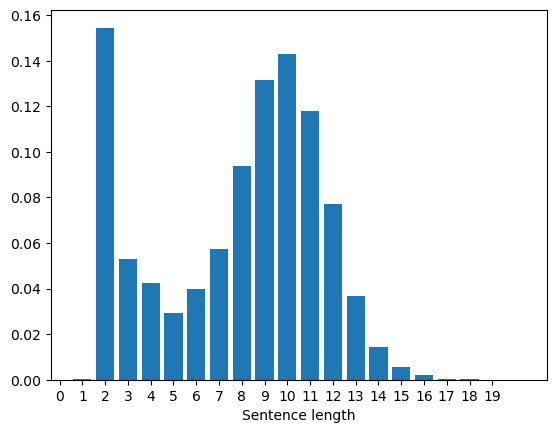

In [4]:
fraction_of_seq_lengths = {k: v / len(sentence_lengths) for k, v in Counter(sentence_lengths).items()}
plt.bar(fraction_of_seq_lengths.keys(), fraction_of_seq_lengths.values(), label='Seq Length distribution')
plt.xticks(np.arange(0, len(longest_sentence), 1))
plt.xlabel('Sentence length')
plt.savefig('./figs/seq_length_distribution.png')

# Encoding Dataloader checks

Double check one hot encoding and decoding is working as expected

In [5]:
WORD_MANAGER_PATH = 'data/word2vec.model'
word2vec_manager = WordEmbeddingManager(WORD_MANAGER_PATH)

Model loaded successfully from data/word2vec.model


In [6]:
# dataloader = create_embedding_dataloader(tokenized_sentences, word2vec_manager, seq_length=SEQ_LENGTH, batch_size=4, encoding_method="one_hot", verbose=True)
# batch = next(iter(dataloader))
# print(f'first batch sentence: {batch[0]}')
# encoded_first_sentence = batch[0]
# decoded_first_sentence = [word2vec_manager.decode_one_hot(encoded_token) for encoded_token in encoded_first_sentence]
# decoded_first_sentence


In [7]:
# sentence_to_encode = ['That', 'you', 'have', "ta'en", 'a', 'tardy', '<UNK>', 'here', '.', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
# encoded_sentence = [word2vec_manager.one_hot_encode(word) for word in sentence_to_encode]
# decoded = [word2vec_manager.decode_one_hot(one_hot) for one_hot in encoded_sentence]
# encoded_sentence,decoded

# Start model training

In [8]:
# Initialize models
SEQ_LENGTH = 15
seq_length = SEQ_LENGTH 

# Generator first

gen_input_dim = embeddings.EMBEDDING_SIZE
gen_hidden_dim = 300

# add 1 to output dim to account for padding token
gen_output_dim = len(word2vec_manager._model.wv.key_to_index) + 1

generator = Generator(input_size=gen_input_dim, hidden_size=gen_hidden_dim, output_size=gen_output_dim, seq_length=seq_length)


# Discriminator
# Discriminator input is the same as the generator output (the generated next token probability distribution)
discrim_input_dim = gen_output_dim
discrim_hidden_dim = 100

discriminator = Discriminator(input_dim=discrim_input_dim, hidden_dim=discrim_hidden_dim, seq_length=seq_length)

In [9]:
discrim_params = list(discriminator.parameters())
gen_params = list(generator.parameters())
num_params_gen = sum([np.prod(p.size()) for p in gen_params])
num_params_discrim = sum([np.prod(p.size()) for p in discrim_params])
print(f'Generator has {num_params_gen} parameters')
print(f'Discriminator has {num_params_discrim} parameters')

Generator has 2485755 parameters
Discriminator has 2782901 parameters


In [10]:
# Train models

# Hyperparameters
learning_rate = 0.0001
batch_size = 4
temperature = 1.0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 1
TRAIN_AND_VAL_FRAC = 1.0
if TRAIN_AND_VAL_FRAC != 1.0:
    train_val, rest = train_test_split(tokenized_sentences, train_size=TRAIN_AND_VAL_FRAC, random_state=42)
    train_sents, val_sents = train_test_split(train_val, train_size=0.8, random_state=42)
else:
    train_sents, val_sents = train_test_split(tokenized_sentences, train_size=0.9, random_state=42)



In [11]:
def generate_sentences(generator, temp):
    gens = []
    for i in range(10):
        noise = torch.randn(1, seq_length, gen_input_dim)
        generated_data = generator(noise, temperature, hard=False)
        argmaxs = torch.argmax(generated_data[0], dim=1)
        generated_sentence = [word2vec_manager.index_to_word(index) for index in argmaxs]
        gens.append(" ".join(generated_sentence).replace("<PAD>", ""))
    return gens

In [12]:
def test_hyperparams(possible_hyperparams, num_epochs, train_sents, val_sents, word2vec_manager, metrics_dir, calc_perplexity):
    assert len(possible_hyperparams.keys()) == 4 and set(possible_hyperparams.keys()) == set(['lr', 'temp', 'batch_size', 'seq_length'])
    num_iterations = np.prod([len(possible_hyperparams[key]) for key in possible_hyperparams.keys()])
    current_iteration = 0
    results = []
    for lr in possible_hyperparams['lr']:
        for temp in possible_hyperparams['temp']:
            for batch_size in possible_hyperparams['batch_size']:
                for seq_length in possible_hyperparams['seq_length']:
                    current_iteration += 1
                    print(f'Iteration {current_iteration} of {num_iterations}')
                    print(f'lr={lr}, temp={temp}, batch_size={batch_size}, seq_length={seq_length}')
                    generator = Generator(input_size=gen_input_dim, hidden_size=gen_hidden_dim, output_size=gen_output_dim, seq_length=seq_length)
                    discriminator = Discriminator(input_dim=discrim_input_dim, hidden_dim=discrim_hidden_dim, seq_length=seq_length)
                    g_loss, d_loss =train_gan(
                            generator=generator,
                            discriminator=discriminator,
                            generator_lr = lr,
                            discriminator_lr = lr,
                            validation_sentences=val_sents,
                            training_sentences=train_sents,
                            word2vec_manager=word2vec_manager,
                            calc_perplexity=calc_perplexity,
                            seq_length=SEQ_LENGTH,
                            generator_input_features=gen_input_dim,  # Updated parameter name
                            num_epochs=num_epochs,
                            batch_size=batch_size,
                            noise_sample_method="normal",
                            gumbel_hard=True,
                            temperature=temp,
                            encoding_method="one_hot",
                            device=device,
                            tensorboard_log_dir=metrics_dir
                        )
                    gens = generate_sentences(generator, temp)
                    results.append((lr, temp, batch_size, seq_length, g_loss, d_loss, generator, discriminator, gens))
                    print(f'Generated sentences: {gens[:2]}')
    return results
              

In [13]:
ngram_for_perplexity = ngram_module.NGRAM_Model(4, scoring_method='LI_grid_search')
ngram_for_perplexity.train(train_sents)

In [14]:
calc_perplexity = lambda sentences: gan_module.estimate_perplexity(sentences, ngram_for_perplexity)

In [15]:
import shutil
def prepare_metrics_dir(log_dir):
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    else:
        # clear existing logs
        for f in os.listdir(log_dir):
            if os.path.isdir(os.path.join(log_dir, f)):
                shutil.rmtree(os.path.join(log_dir, f))
            else:
                os.remove(os.path.join(log_dir, f))

def run_experiment(possible_hyperparams, experiment_id, num_epochs, train_sents, val_sents, word2vec_manager, calc_perplexity, log_dir_base):
    log_dir = os.path.join(log_dir_base, "hyperparameter_search_" + experiment_id)
    prepare_metrics_dir(log_dir)
    results = test_hyperparams(possible_hyperparams, num_epochs, train_sents, val_sents, word2vec_manager, log_dir, calc_perplexity)          
    return results

In [16]:
BEST_BATCH_MODEL_PATH = './models/generator_batch_size_4.pt'
if os.path.exists(BEST_BATCH_MODEL_PATH):
    generator = gan_module.load_gen_model(BEST_BATCH_MODEL_PATH, gen_input_dim, gen_hidden_dim, gen_output_dim, seq_length)
    batch_size_results = [(0.001, 1.0, 4, 15, 0.0, 0.0, generator, None, generate_sentences(generator, 1.0))]
else:
    possible_hyperparams = {
        'lr': [0.001],
        'batch_size': [4, 16, 32],
        'temp': [1.0],
        'seq_length': [15],
    }
    batch_size_results = run_experiment(possible_hyperparams, "batch_size", num_epochs, train_sents, val_sents, word2vec_manager, calc_perplexity, LOG_DIR_BASE)

Missing keys: []
Unexpected keys: []


In [17]:
batch_size_results

[(0.001,
  1.0,
  4,
  15,
  0.0,
  0.0,
  Generator(
    (lstm): LSTM(50, 300, batch_first=True)
    (fc): Linear(in_features=300, out_features=6855, bias=True)
    (ls): LogSoftmax(dim=2)
  ),
  None,
  ['EDWARD they they they they they they they they they they they they they they',
   'pass they they they they they they they they they they they they they they',
   'conceive breathed they they they they they they they they they they they they they',
   'forfeits they they they they they they they they they they they they they they',
   'ill they they they they they they they they they they they they they they',
   'adversary they they they they they they they they they they they they they they',
   'Jule may they they they they they they they they they they they they they',
   'chairs they they they they they they they they they they they they they they',
   'marvellous weigh they they they they they they they they they they they they they',
   'destined violent they they they they t

In [18]:
BEST_SEQ_LENGTH_MODEL_PATH = './models/generator_seq_length_13.pt'
if os.path.exists(BEST_SEQ_LENGTH_MODEL_PATH):
    generator = gan_module.load_gen_model(BEST_SEQ_LENGTH_MODEL_PATH, gen_input_dim, gen_hidden_dim, gen_output_dim, seq_length)
    seq_length_results = [(0.001, 1.0, 4, 13, 0.0, 0.0, generator, None, generate_sentences(generator, 1.0))]
else:
    possible_hyperparams = {
        'lr': [0.001],
        'batch_size': [16],
        'temp': [1.0],
        'seq_length': [13,15],
    }
    seq_length_results = run_experiment(possible_hyperparams, "seq_length", num_epochs, train_sents, val_sents, word2vec_manager, calc_perplexity, LOG_DIR_BASE)


Missing keys: []
Unexpected keys: []


In [19]:
seq_length_results

[(0.001,
  1.0,
  4,
  13,
  0.0,
  0.0,
  Generator(
    (lstm): LSTM(50, 300, batch_first=True)
    (fc): Linear(in_features=300, out_features=6855, bias=True)
    (ls): LogSoftmax(dim=2)
  ),
  None,
  ['burthen devil not the of to of the  of  :  not not',
   'accusations suck the to for thou for lord  of will in the : of',
   'forswore A . you of . is of in you . the : to do',
   'battlements Are in to to in we the  of your of the to in',
   'Jacks posts of of we will the <UNK> of of in . . in of',
   'repetition ensue in he : the to you . come   of of the',
   'making yourself to the in of your the we of . of in not you',
   'despairing will of the the to <UNK> the you for  in in of you',
   'CAPULET most to of go your of the KING of in the in of in',
   "tyrannous traveller the in  ' of of : the  to thou the of"])]

In [20]:
BEST_TEMP_MODEL_PATH = './models/generator_temp_1.0.pt'
if os.path.exists(BEST_TEMP_MODEL_PATH):
    generator = gan_module.load_gen_model(BEST_TEMP_MODEL_PATH, gen_input_dim, gen_hidden_dim, gen_output_dim, seq_length)
    temp_results = [(0.001, 1.0, 4, 15, 0.0, 0.0, generator, None, generate_sentences(generator, 1.0))]
else:
    possible_hyperparams = {
        'lr': [0.001],
        'batch_size': [16],
        'temp': [1.0, 1.5],
        'seq_length': [15],
    }

    temp_results = run_experiment(possible_hyperparams, "temp", num_epochs, train_sents, val_sents, word2vec_manager, calc_perplexity, LOG_DIR_BASE)

Missing keys: []
Unexpected keys: []


In [21]:
temp_results

[(0.001,
  1.0,
  4,
  15,
  0.0,
  0.0,
  Generator(
    (lstm): LSTM(50, 300, batch_first=True)
    (fc): Linear(in_features=300, out_features=6855, bias=True)
    (ls): LogSoftmax(dim=2)
  ),
  None,
  ['perceives titles feigned rashly carriage lucky unking pins pins tumble Does request Fie tumble tumble',
   'rust Between GLOUCESTER ISABELLA peer Boldly molehill peer molehill Thou Such molehill serve peer conquer',
   "elders blow Behold smear wander pedlar Lady devour went'st farthest nigh Bad lovest lucky question",
   'Stop used mistrust station Base lungs fights push Willoughby lolling tumble request tumble dismal Proceed',
   'seeming senseless gain killed prevail April lucky dissolution prevail Pronounce enjoy tumble Through push pomp',
   "deer deposed person hostile question 'Bless rarest sweet'st fined lucky lolling fined lolling unjustly pretty",
   'wet honourably stamps rings revenue Lives HENRY serve revenue molehill honourably molehill helm peer men',
   'Inquire real

In [24]:
BEST_LR_MODEL_PATH = './models/generator_lr_0.0001.pt'
if os.path.exists(BEST_LR_MODEL_PATH):
    generator = gan_module.load_gen_model(BEST_LR_MODEL_PATH, gen_input_dim, gen_hidden_dim, gen_output_dim, seq_length)
    lr_results = [(0.0001, 1.0, 16, 15, 0.0, 0.0, generator, None, generate_sentences(generator, 1.0))]
else:
    possible_hyperparams = {
        'lr': [0.0001],
        'batch_size': [16],
        'temp': [1.0],
        'seq_length': [15],
    }

    lr_results = run_experiment(possible_hyperparams, "lr", num_epochs, train_sents, val_sents, word2vec_manager, calc_perplexity, LOG_DIR_BASE)

Iteration 1 of 1
lr=0.0001, temp=1.0, batch_size=16, seq_length=15


Epoch 1/1:   0%|          | 0/1645 [00:00<?, ?it/s]

Epoch 1/1 | Generator Loss: 0.9353 | Discriminator Loss: 1.4708:  18%|█▊        | 290/1645 [01:52<08:46,  2.57it/s]

Perplexity is too low, stopping training
Generated sentences: ['kingdoms I             ', 'soothe ensue             ']


In [25]:
lr_results

In [27]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

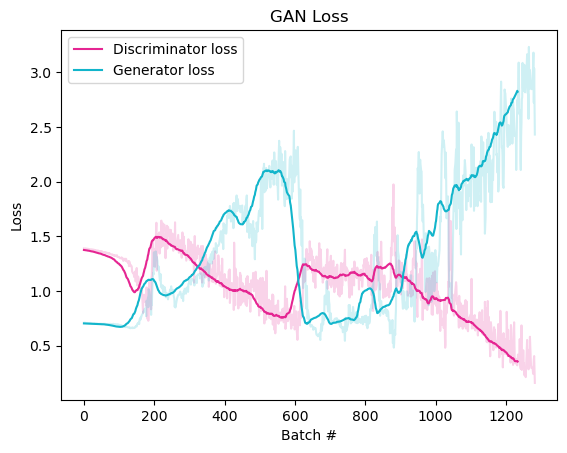

In [28]:
DISCRIM_LOSS_CSV_PATH = 'metrics/Loss _ Train_Discriminator Loss.csv'
GEN_LOSS_CSV_PATH = 'metrics/Loss _ Train_Generator Loss.csv'
GAN_LOSS_PLOT_PATH = 'figs/gan_loss_plot.png'

import pandas as pd
discrim_loss_df = pd.read_csv(DISCRIM_LOSS_CSV_PATH)
gen_loss_df = pd.read_csv(GEN_LOSS_CSV_PATH)

window_size = 40

smoothed_discrim_loss = moving_average(discrim_loss_df['Value'], window_size)
smoothed_gen_loss = moving_average(gen_loss_df['Value'], window_size)


plt.plot(discrim_loss_df['Step'], discrim_loss_df['Value'], alpha=0.2, c='#e52592')
plt.plot(gen_loss_df['Step'], gen_loss_df['Value'], alpha=0.2, c='#12b5cb')
plt.plot(discrim_loss_df['Step'][:-(window_size - 1)], smoothed_discrim_loss, label='Discriminator loss', c='#e52592')
plt.plot(gen_loss_df['Step'][:-(window_size - 1)], smoothed_gen_loss, label='Generator loss', c='#12b5cb')
plt.xlabel('Batch #')
plt.ylabel('Loss')
plt.title('GAN Loss')
# log scale
plt.legend()

plt.savefig(GAN_LOSS_PLOT_PATH)

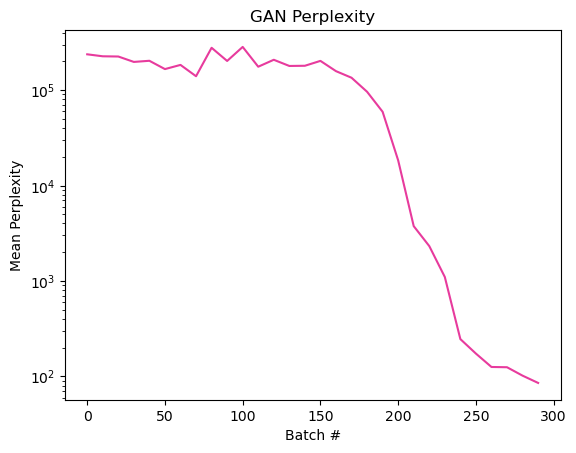

In [32]:
# now plot perplexity
PERPLEXITY_CSV_PATH = 'metrics/perplexity.csv'
perplexity_df = pd.read_csv(PERPLEXITY_CSV_PATH)
plt.plot(perplexity_df['Step'], perplexity_df['Value'], alpha=0.9, c='#e52592')
plt.xlabel('Batch #')
plt.ylabel('Mean Perplexity')
#log scale
plt.title('GAN Perplexity')
plt.yscale('log')
plt.savefig('figs/gan_perplexity_plot1.png')
# log scale

In [ ]:
 possible_hyperparams = {
        'lr': [0.0001],
        'batch_size': [16],
        'temp': [1.0],
        'seq_length': [15],
    }

lr_results = run_experiment(possible_hyperparams, "lr", num_epochs, train_sents, val_sents, word2vec_manager, calc_perplexity, LOG_DIR_BASE)